In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [2]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [5]:
resnet_weights_path = r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
from tensorflow.python.keras import optimizers
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [9]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [10]:
image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\catsdogs-trainvalid-80pc-prepd\trainvalidfull4keras\trainvalidfull4keras\train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\catsdogs-trainvalid-80pc-prepd\trainvalidfull4keras\trainvalidfull4keras\valid',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [17]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,#steps * batch does not equal to 20000, beacause batch image generator will shuffer the data before outputs the batches
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\best.hdf5')

Epoch 1/10
10/10 [==============================] - 285s 29s/step - loss: 0.0851 - acc: 0.9690 - val_loss: 0.0535 - val_acc: 0.9840
Epoch 2/10
10/10 [==============================] - 290s 29s/step - loss: 0.0545 - acc: 0.9770 - val_loss: 0.0466 - val_acc: 0.9860
Epoch 3/10
10/10 [==============================] - 291s 29s/step - loss: 0.0755 - acc: 0.9690 - val_loss: 0.0498 - val_acc: 0.9860
Epoch 4/10
10/10 [==============================] - 295s 29s/step - loss: 0.0939 - acc: 0.9660 - val_loss: 0.0492 - val_acc: 0.9830
Epoch 5/10
10/10 [==============================] - 293s 29s/step - loss: 0.0762 - acc: 0.9680 - val_loss: 0.0431 - val_acc: 0.9860
Epoch 6/10
10/10 [==============================] - 289s 29s/step - loss: 0.0833 - acc: 0.9680 - val_loss: 0.0462 - val_acc: 0.9850
Epoch 7/10
10/10 [==============================] - 288s 29s/step - loss: 0.0508 - acc: 0.9810 - val_loss: 0.0480 - val_acc: 0.9870
Epoch 8/10
10/10 [==============================] - 292s 29s/step - loss: 0.

## Training Metrics¶
One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics (training accuracy, training loss, validation loss & validation accuracy) for each epoch. Note that training accuracy & loss during epoch steps are somewhat incomplete information and they are not recorded in history.

Observe that training uses early stopping, hence metrics is available for epochs run, not for NUM_EPOCHS.

In [16]:
import pickle

In [18]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(fit_history.history, file_pi)

In [19]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


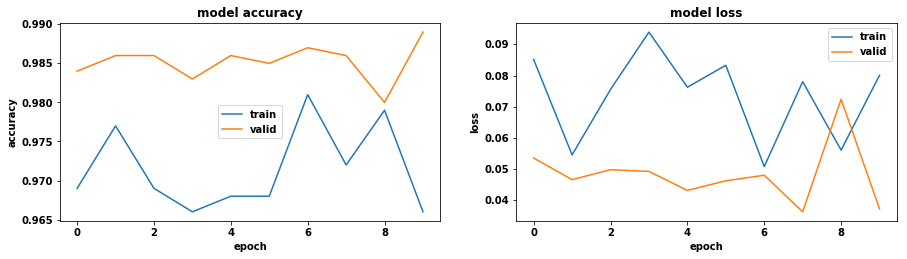

In [20]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [22]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\test-files-prepd\test4keras\test4keras',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 12500 images belonging to 1 classes.


In [23]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

12500/12500 [==============================] - 1247s 100ms/step


In [28]:
predicted_class_indices

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

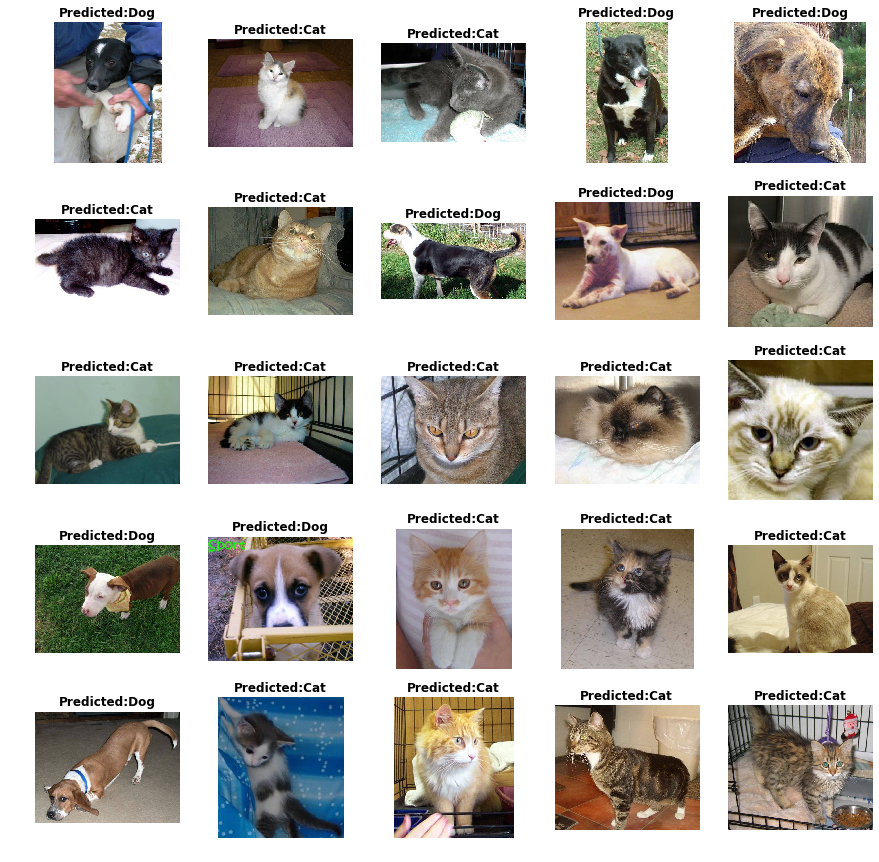

In [54]:
TEST_DIR = r'D:\sgmuserprofile\sjbgwk\kaikeba_Assignment\Assignment 13\test-files-prepd\test4keras\test4keras'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + '\\'+ test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()